# Initial Imports

In [9]:
import pandas as pd
import numpy as np
from nltk import ngrams
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import ImageColorGenerator
pd.options.plotting.backend = 'hvplot'

# Custom .py files
from get_lyric_data import get_lyrics
from get_chart_data import get_chart_genre
from text_processor import process_text

# Lyric Data

### Search for top songs in GENRE

In [10]:
""" SHAZAM CORE API REQUEST """
""" WORLD CHART BY GENRE ENDPOINT """

# Use 'World Chart By Genre' endpoint to retrieve chart for a single genre

# GENRE CODES
# POP,HIP_HOP_RAP,DANCE,ELECTRONIC,SOUL_RNB,ALTERNATIVE,ROCK,LATIN,FILM_TV,COUNTRY,
# AFRO_BEATS,WORLDWIDE,REGGAE_DANCE_HALL,HOUSE,K_POP,FRENCH_POP,SINGER_SONGWRITER,REG_MEXICO

genre = 'COUNTRY'
limit_songs = 50

querystring = {"genre_code": genre,"limit":limit_songs}
chart_response = get_chart_genre(querystring)

In [11]:
# Retrieve Track IDs

track_ids=[] # song identifier
titles = [] # song name
subtitles = [] # Main artist and featured artists

for track in range(len(chart_response)):
    track_ids.append(chart_response[track]['id'])
    titles.append(chart_response[track]['title'])
    subtitles.append(chart_response[track]['subtitle'])

print(f"The number of songs retrieved is : {len(track_ids)}")

chart_songs = pd.DataFrame({"Track Name": titles, "Artists": subtitles, 'TrackIDs': track_ids}).set_index('TrackIDs')
chart_songs.head(5)


The number of songs retrieved is : 50


,Track Name,Artists
TrackIDs,,
595243928,The Cowboy In Me (Yellowstone Edition),Tim McGraw
54640449,Jingle Bell Rock,Bobby Helms
568180108,Fancy Like,Walker Hayes
52815945,Enchanted,Taylor Swift
463807349,Old Town Road (Remix),Lil Nas X Feat. Billy Ray Cyrus


In [12]:
# Take a look at the data

from collections import Counter

artists_list = list(chart_songs.Artists)
artist_counts = {artist: artists_list.count(artist) for artist in artists_list} #dict with frequency of artist in top chart

artists_df = pd.DataFrame(list(artist_counts.items()),columns = ['Artists','No. Songs in Top Chart']).set_index('Artists')
artists_df.sort_values(by = 'No. Songs in Top Chart', ascending=False, inplace=True) #sort values

# Plot artists frequency in top chart
genre_plot = artists_df.plot.bar(rot=90, width = 1000, height = 600, color = 'yellow', title = f'ARTISTS ON {genre} TOP CHART')
genre_plot

:Bars   [Artists]   (No. Songs in Top Chart)

### Search lyrics by TRACK

In [13]:
""" SHAZAM CORE API REQUEST """
""" TRACK DETAILS ENDPOINT """

# Retrieve Lyrics for all TrackIDs

track_ids  # the list created in "Search for top songs in Genre" section is required

lyrics=[]

for trackID in track_ids:
    querystring = {"track_id":trackID}
    track_details_response = get_lyrics(querystring)

    if track_details_response['sections'][1]['type'] != "LYRICS":  # Note: tracks with a type != "LYRICS" don't contain lyrics
        lyrics.append([''])
    else:
        track_lyrics = track_details_response['sections'][1]['text']
        lyrics.append(track_lyrics)

### Generate Lyrics DataFrame

In [14]:
# Add lyrics column to dataframe with chart songs

all_lyrics = pd.Series(" ".join(map(str,song)) for song in lyrics) #each song is stored as a list, this turns each list into a string
all_lyrics_df = pd.DataFrame({"Lyrics": all_lyrics, "Track IDs": track_ids}).set_index('Track IDs')

lyrics_df = pd.concat([chart_songs, all_lyrics_df], axis=1)
lyrics_df.head(5)

,Track Name,Artists,Lyrics
595243928,The Cowboy In Me (Yellowstone Edition),Tim McGraw,
54640449,Jingle Bell Rock,Bobby Helms,"Jingle bell, jingle bell, jingle bell rock Jin..."
568180108,Fancy Like,Walker Hayes,Ayy My girl is bangin' She's so low maintenanc...
52815945,Enchanted,Taylor Swift,"There I was again tonight Forcing laughter, fa..."
463807349,Old Town Road (Remix),Lil Nas X Feat. Billy Ray Cyrus,"Oh, oh-oh Oh Yeah, I'm gon' take my horse to ..."


In [15]:
# Remove songs without lyrics

lyrics_df.drop(lyrics_df.loc[lyrics_df['Lyrics'] == ''].index.tolist(), inplace=True)
lyrics_df.head(5)

,Track Name,Artists,Lyrics
54640449,Jingle Bell Rock,Bobby Helms,"Jingle bell, jingle bell, jingle bell rock Jin..."
568180108,Fancy Like,Walker Hayes,Ayy My girl is bangin' She's so low maintenanc...
52815945,Enchanted,Taylor Swift,"There I was again tonight Forcing laughter, fa..."
463807349,Old Town Road (Remix),Lil Nas X Feat. Billy Ray Cyrus,"Oh, oh-oh Oh Yeah, I'm gon' take my horse to ..."
504707938,West Texas In My Eye,The Panhandlers,Lately I've been thinking that I could leave t...


In [16]:
# Find frequency of specific word
lyrics_df['Lyrics'].str.count('oh').sum()

134

### Export lyrics to a single .txt file

In [17]:
# Export lyrics to .txt file

text = ' '.join(lyrics_df['Lyrics'].tolist())

file = open('country_text.txt', 'w')
file.write(text)

print(text[:1000])

Jingle bell, jingle bell, jingle bell rock Jingle bells swing and jingle bells ring Snowing and blowing up bushels of fun Now the jingle hop has begun  Jingle bell, jingle bell, jingle bell rock Jingle bells chime in jingle bell time Dancing and prancing in Jingle Bell Square In the frosty air  What a bright time, it's the right time To rock the night away Jingle bell time is a swell time To go riding in a one-horse sleigh  Giddy-up jingle horse, pick up your feet Jingle around the clock Mix and a-mingle in the jingling beat That's the jingle bell rock  Jingle bell, jingle bell, jingle bell rock Jingle bells chime in jingle bell time Dancing and prancing in Jingle Bell Square In the frosty air  What a bright time, it's the right time To rock the night away Jingle bell time is a swell time To go riding in a one-horse sleigh  Giddy-up jingle horse, pick up your feet Jingle around the clock Mix and a-mingle in the jingling beat That's the jingle bell That's the jingle bell That's the jing

# Sentiment Analysis

# Natural Language Processing

### Tokenizer

In [18]:
# Create a list of stopwords
sw_custom = {'wouldnt','got', 'get','would','ohoh','oh','youll','wan','tell', 'see','wouldn','didnt', 'there', 'theres','said', 'youve', 'wa', 'dont', 'cant', 'oh','ive', 'ill', 'na', 'youre', 'gon', 'im', 'go', 'id', 'say', 'aint', 'oh', 'jingle', 'bell', 'santa', 'claus'}

# Run the text_processor function for lyrics dataframe
lyrics_tokenized = [process_text(text, sw_custom) for text in lyrics_df['Lyrics']]

# Create a new tokens column for dataframe
lyrics_df['Tokens'] = lyrics_tokenized
lyrics_df.head(3)

,Track Name,Artists,Lyrics,Tokens
54640449,Jingle Bell Rock,Bobby Helms,"Jingle bell, jingle bell, jingle bell rock Jin...","[rock, swing, ring, snowing, blowing, bushel, ..."
568180108,Fancy Like,Walker Hayes,Ayy My girl is bangin' She's so low maintenanc...,"[ayy, girl, bangin, shes, low, maintenance, ne..."
52815945,Enchanted,Taylor Swift,"There I was again tonight Forcing laughter, fa...","[tonight, forcing, laughter, faking, smile, ol..."


### N-Grams and Frequency Analyzer

In [19]:
# Frequency Analysis

# Function token_count generates the top N words for given text
def token_count(tokens, n_results):
    """ Returns the top N tokens """
    """ Requires a dataframe series as input"""
    big_string = ' '.join(map(str,tokens))
    processed = process_text(big_string, sw_custom)
    topN = dict(Counter(processed).most_common(n_results))
    return pd.DataFrame(list(topN.items()), columns=['Word', 'Count']).set_index('Word')

# Plot most common tokens
top_words = token_count(lyrics_df['Tokens'],50)
top_words.plot.bar(rot=90, width=1000, color='yellow', title =f'Top Words for {genre}')


:Bars   [Word]   (Count)

### Word Cloud

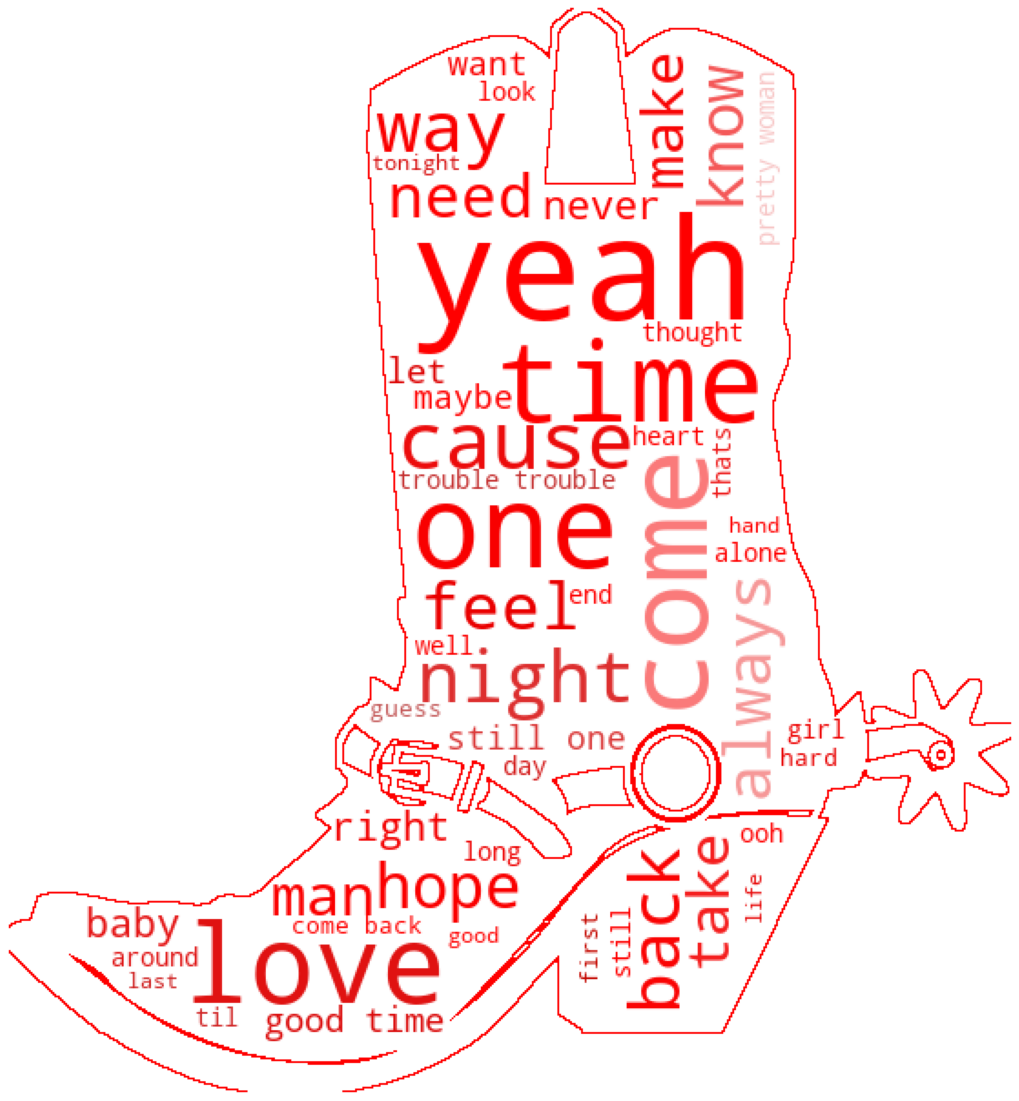

In [23]:
# Generate a word cloud image

# Text for word cloud

big_string = ' '.join(lyrics_df['Lyrics'])
lyrics_text = process_text(big_string, sw_custom)

# Add mask
mask = np.array(Image.open("images/cowboy-boot.png"))

# Create Word Cloud
wc_boot = WordCloud(contour_width=1, contour_color='red', width=2000, height=2000, background_color="white", max_words=50, mask=mask).generate(' '.join(lyrics_text))

# Create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(20,20))
plt.imshow(wc_boot.recolor(color_func=image_colors), interpolation="bilinear")

plt.axis("off")
plt.imshow(wc_boot)

# Save image as png
wc_boot.to_file("images/country.png")

# Name Entity Recognition

# Next Word Prediction

Using Language Model Module (nltk.lm) from NLTK library

--Kneser-Ney Interpolated algorithm or MLE--